In [2]:
import sys, warnings
sys.path.append('../code/')
import pandas as pd
import numpy as np
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import SCORERS, mean_squared_error, median_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor


if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [4]:
# create a new NN

# classifiers
reg_dict = {
    'Linear Regression': LinearRegression(), 
    'Feed-Forward Neural Network': MLPRegressor(max_iter=500),
    'Random Forest Regressor': RandomForestRegressor(),
    'Dummy Regressor (Mean)': DummyRegressor(strategy='mean')}

# parameters for each classifier
params_dict = {
    'Linear Regression' : {},
    'Feed-Forward Neural Network': {'hidden_layer_sizes': [(50,50,50), (16, 32, 16)],
                                    'activation': ['relu','tanh'],
                                    'alpha': [0.0001, 0.05]},
    'Random Forest Regressor': {},
    'Dummy Regressor (Mean)': {}}

# best model with specific parameters for each classifier
models_dict = {
    'Linear Regression': None, 
    'Feed-Forward Neural Network': None,
    'Random Forest Regressor': None,
    'Dummy Regressor (Mean)': None}

In [5]:
cnames = ['_3_hour', '', '_half_hour', '_1_hour', '_2_hour', '_6_hour', '_12_hour', '_24_hour']

crops, lin_crops,  models, mses, maes, coefs, feature_names = [], [], [], [], [], [], []
preds = {}

nmodels = len(models_dict)

# loop through crops
for c in cnames:
    
    print('started', c, flush=True)

    df_train = pd.read_csv('../data/grouped' + c + '.csv').sample(frac=1)
    df_test = pd.read_csv('../data/grouped' + c + '_test.csv').sample(frac=1)
    
    df_train_dropped = df_train.drop(['cascade_id', 'cascade_size_log', 'cascade_followers_log', 'cascade_size', 'cascade_followers'], axis = 1)
    df_test_dropped = df_test.drop(['cascade_id', 'cascade_size_log', 'cascade_followers_log', 'cascade_size', 'cascade_followers'], axis = 1)

    X_train, y_train = df_train_dropped.values, df_train.cascade_size_log.values
    X_test, y_test = df_test_dropped.values, df_test.cascade_size_log.values

    feature_name = df_train_dropped.columns.tolist()
    feature_names += feature_name
    
    pred = df_test[['cascade_id', 'cascade_size_log']]

    # if no crop --> full
    crop = ''
    if c:
        crop = [c[1:]]
        crops += crop* nmodels
        lin_crops += crop * len(feature_name)
    else:
        crop = ['full']
        crops += crop * nmodels
        lin_crops += crop * len(feature_name)

    for name, reg in tqdm(reg_dict.items()):
        if c == '_3_hour':

            model = reg

            params = params_dict[name]

            grid = GridSearchCV(model, params,  scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

            grid.fit(X_train, y_train)

            model = grid.best_estimator_

            # store best model in model_dicts
            models_dict[name] = model

        # fit model and predict for every crop
        model = models_dict[name]

        model.fit(X_train, y_train)
            
        y_hat = model.predict(X_test)
        pred['y_hat_'+name] = y_hat
        mse = mean_squared_error(y_test, y_hat)
        mae = median_absolute_error(y_test, y_hat)

        models.append(name)
        mses.append(mse)
        maes.append(mae)

        if name == 'Linear Regression':
            coefs += model.coef_.tolist()

    
    preds[crop[0]] = pred 

results = pd.DataFrame({'crop':crops, 'model':models, 'mse':mses, 'mae':maes})
coefficients = pd.DataFrame({'crop':lin_crops, 'coef':coefs, 'feature_name':feature_names})

started _3_hour
100%|██████████| 4/4 [02:09<00:00, 32.46s/it]started 

100%|██████████| 4/4 [00:04<00:00,  1.17s/it]started _half_hour

100%|██████████| 4/4 [00:07<00:00,  1.95s/it]started _1_hour

100%|██████████| 4/4 [00:07<00:00,  1.98s/it]started _2_hour

100%|██████████| 4/4 [00:06<00:00,  1.68s/it]started _6_hour

100%|██████████| 4/4 [00:05<00:00,  1.35s/it]started _12_hour

100%|██████████| 4/4 [00:06<00:00,  1.62s/it]started _24_hour

100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


In [6]:
preds['3_hour']

,cascade_id,cascade_size_log,y_hat_Linear Regression,y_hat_Feed-Forward Neural Network,y_hat_Random Forest Regressor,y_hat_Dummy Regressor (Mean)
200,81954,6.405228,5.568510,5.227249,5.144280,6.03364
181,81784,6.375025,5.861861,6.387477,6.398967,6.03364
65,80986,4.736198,5.876120,5.608405,5.261500,6.03364
48,80852,4.962845,5.652480,4.649560,5.036385,6.03364
17,80528,4.787492,5.354038,5.043389,5.083164,6.03364
...,...,...,...,...,...,...
277,82485,8.633731,7.044095,7.632482,7.967480,6.03364
131,81536,5.877736,5.898617,6.645686,6.936993,6.03364
246,82270,7.624131,7.667100,7.683106,8.211825,6.03364
40,80740,4.804021,5.470503,5.227037,5.289300,6.03364


In [7]:
# print MSE
(results
.groupby(['model', 'crop'])
.agg({'mse':'mean'})
.reset_index()
.pivot(index='model',columns='crop',values='mse')
.style.format('{:.4f}'))

crop,12_hour,1_hour,24_hour,2_hour,3_hour,6_hour,full,half_hour
model,,,,,,,,
Dummy Regressor (Mean),1.3145,1.3145,1.3145,1.3145,1.3145,1.3145,1.3145,1.3145
Feed-Forward Neural Network,0.3880,0.7095,0.2619,0.5725,0.5180,0.4227,0.0130,0.6777
Linear Regression,0.5495,0.7052,0.4654,0.6672,0.6235,0.5884,0.2407,0.7375
Random Forest Regressor,0.3463,0.5984,0.2377,0.5273,0.4774,0.4100,0.0000,0.6385


In [8]:
# print MAE
(results
.groupby(['model', 'crop'])
.agg({'mae':'median'})
.reset_index()
.pivot(index='model',columns='crop',values='mae')
.style.format('{:.4f}'))

crop,12_hour,1_hour,24_hour,2_hour,3_hour,6_hour,full,half_hour
model,,,,,,,,
Dummy Regressor (Mean),0.8269,0.8269,0.8269,0.8269,0.8269,0.8269,0.8269,0.8269
Feed-Forward Neural Network,0.2707,0.4194,0.2387,0.4443,0.4093,0.3223,0.0572,0.4623
Linear Regression,0.4656,0.5315,0.4370,0.5420,0.5206,0.4929,0.3267,0.5668
Random Forest Regressor,0.2315,0.4338,0.1853,0.3946,0.3549,0.3113,0.0011,0.4791


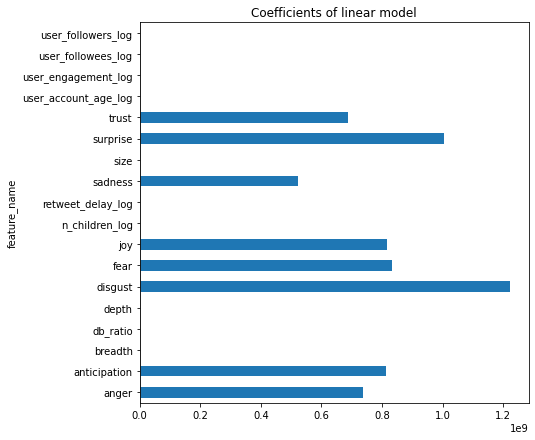

In [10]:
coefficients = coefficients.pivot(index='feature_name', columns='crop', values='coef')
coefficients['full'].plot(kind='barh', figsize=(9, 7))
plt.title('Coefficients of linear model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
#plt.savefig('coeff.png')


In [17]:
# store results
results.to_csv('../data/test_material/baselines_v2.csv', header=True, index=False)